### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
import antropy as ant
import pywt
import warnings

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 


In [5]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [6]:
E78_copy = np.copy(E78)

In [7]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E78_copy)

array([-5.6, -5.6, -5.6, ..., -6.5, -6.5, -6.5])

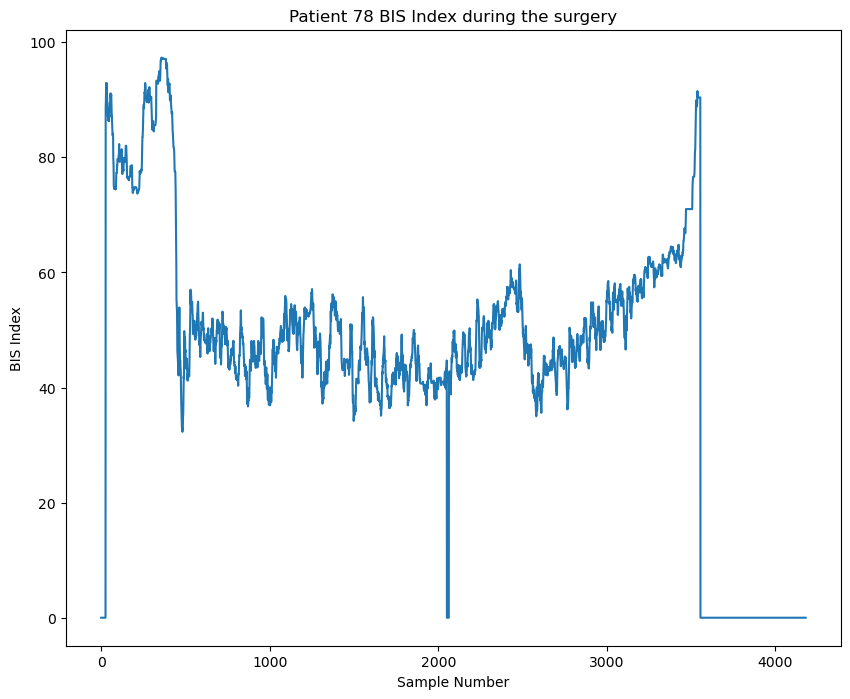

In [8]:
# Patient 78 BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(B78)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patient 78 BIS Index during the surgery")
plt.show()

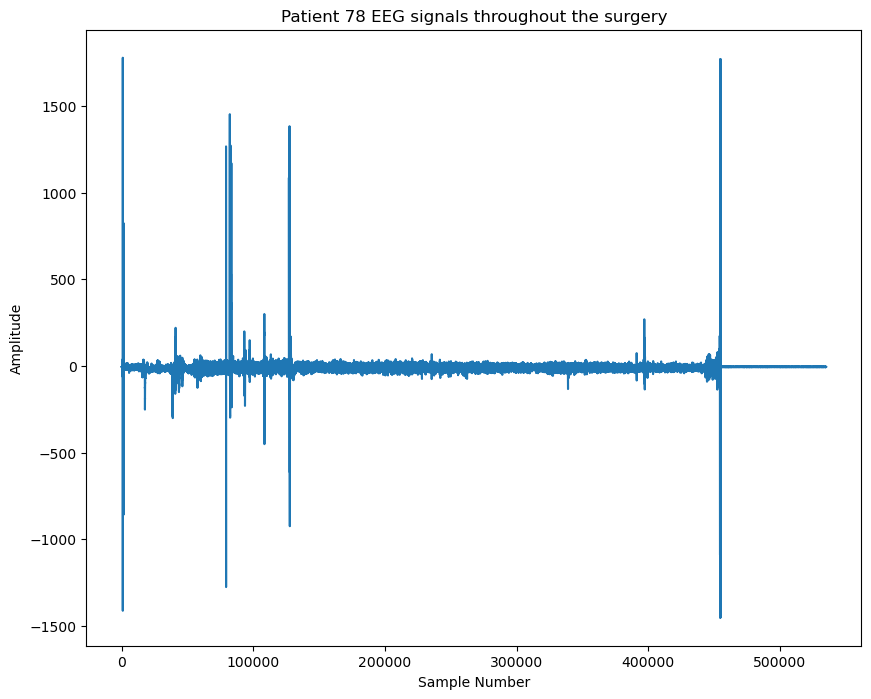

In [9]:
# Patient 78 EEG signals throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(E78)
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Patient 78 EEG signals throughout the surgery")
plt.show()

### Windowing raw EEG signals

In [10]:
# Generate the windows
def windowing(bis, eeg, window_size, sampling_rate, overlap, verbose=False):
    """
    Function to window the raw EEG signals
    
    """
    
    bis_len = len(bis)   


    start, end = 200, 800
    
    eeg_start, eeg_end = 0, end * sampling_rate
    step = window_size - overlap
    
    while True:
        if end > bis_len:
            break
        
        bis_idx = bis[start:end]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        data = namedtuple('EEG', ['eeg', 'bis'])
        
        tup = data(eeg_sample, bis_idx)
        
        if verbose:
            print("EEG Start: {} - {}".format(eeg_start, eeg_end))
        
        yield tup
        
        # update ranges
        start += step
        end += step
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate

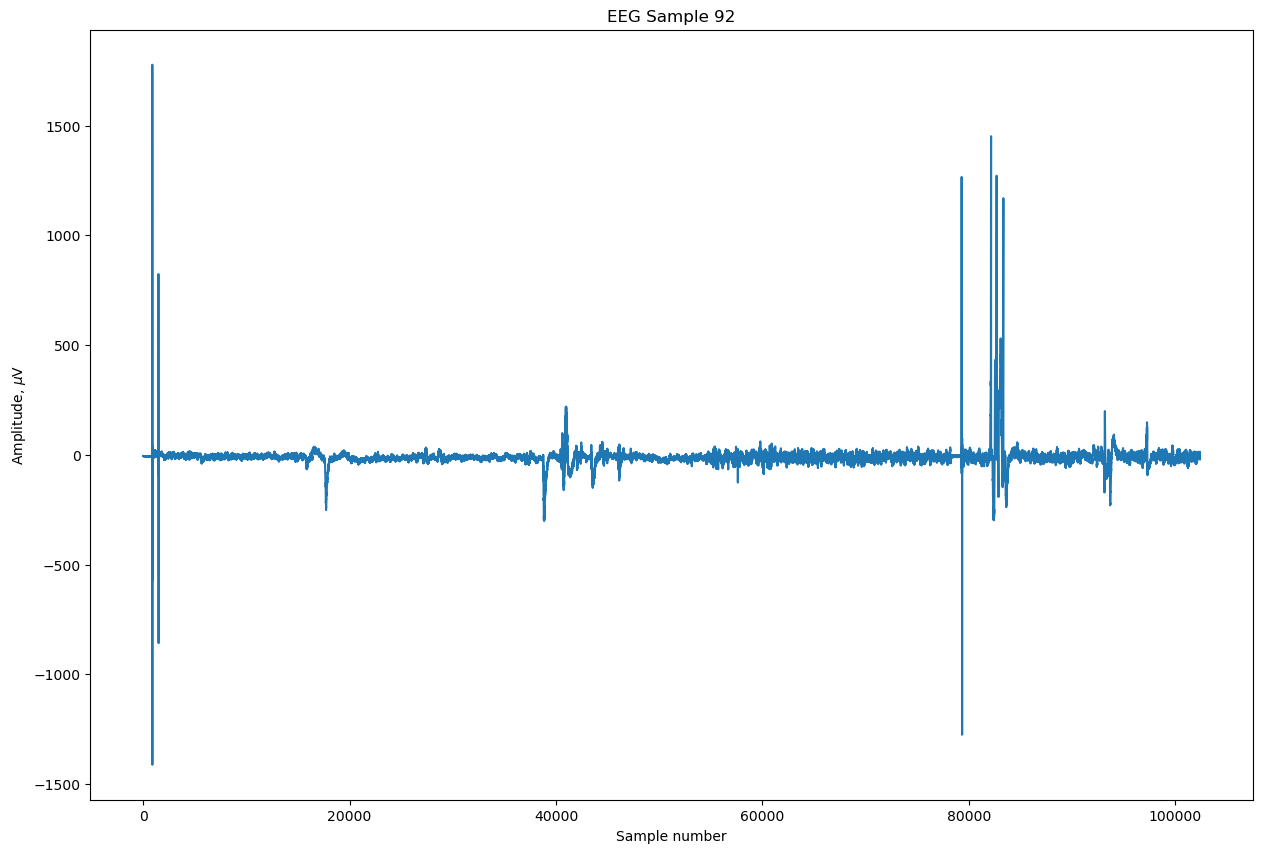

In [11]:
bis = B78
eeg = E78_copy
wind = windowing(bis, eeg, window_size=60, sampling_rate=128, overlap=59, verbose=False)
sample = next(wind)

w_78=sample.eeg
bw_78=sample.bis

figure = plt.figure(figsize=(15, 10))
plt.title("EEG Sample 92")
plt.ylabel("Amplitude, $\mu$V")
plt.xlabel("Sample number")
plt.plot(w_78)
plt.show() 

### Bandpass filtering without windowing

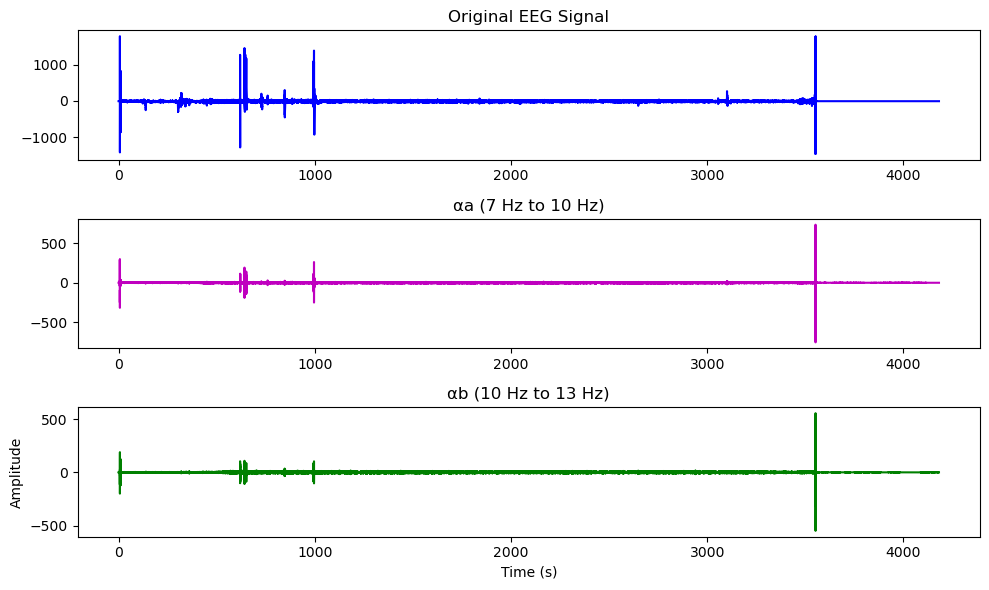

''

In [12]:
""# Define the EEG signal
eeg_signal = E78_copy # Replace with your actual EEG signal

# Define the frequency bands
alpha_a = (7,10)
alpha_b = (10,13)

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
alpha_a_filtered = bandpass_filter(eeg_signal, alpha_a[0], alpha_a[1], fs)
alpha_b_filtered = bandpass_filter(eeg_signal, alpha_b[0], alpha_b[1], fs)


# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs



# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 6))


# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Alpha a band filtered signal
axs[1].plot(time, alpha_a_filtered, 'm')
axs[1].set_title('αa (7 Hz to 10 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Alpha b band filtered signal
axs[2].plot(time, alpha_b_filtered, 'g')
axs[2].set_title('αb (10 Hz to 13 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



plt.tight_layout()
plt.show()

""

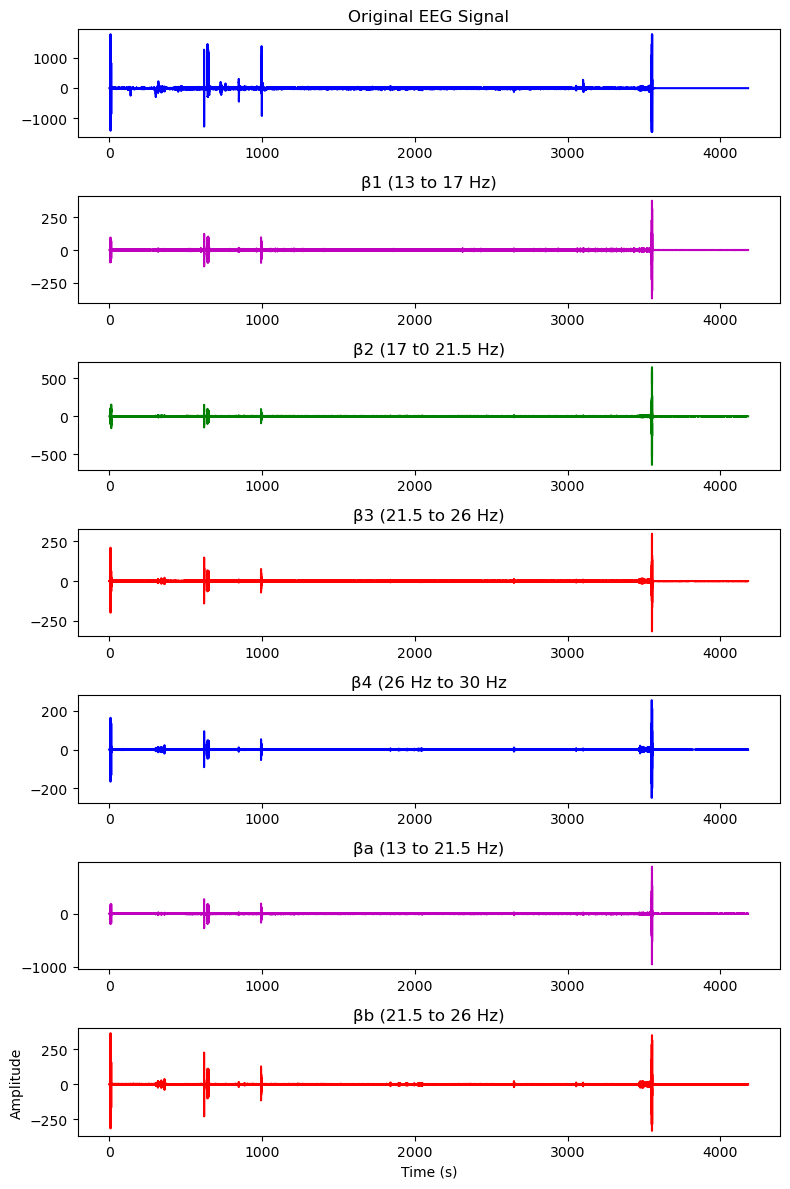

''

In [13]:
""# Define the EEG signal
eeg_signal = E78_copy # Replace with your actual EEG signal

# Define the frequency bands
beta_1 = (13,17)
beta_2 = (17,21.5)
beta_3 = (21.5,26)
beta_4 = (26,30)
beta_a = (13,21.5)
beta_b = (21.5,30)

# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
beta_1_filtered = bandpass_filter(eeg_signal, beta_1[0], beta_1[1], fs)
beta_2_filtered = bandpass_filter(eeg_signal, beta_2[0], beta_2[1], fs)
beta_3_filtered = bandpass_filter(eeg_signal, beta_3[0], beta_3[1], fs)
beta_4_filtered = bandpass_filter(eeg_signal, beta_4[0], beta_4[1], fs)
beta_a_filtered = bandpass_filter(eeg_signal, beta_a[0], beta_a[1], fs)
beta_b_filtered = bandpass_filter(eeg_signal, beta_b[0], beta_b[1], fs)

# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

# Create a figure and subplots
fig, axs = plt.subplots(7, 1, figsize=(8, 12))


#plt.figure(figsize=(12, 8))

# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 1 band filtered signal
axs[1].plot(time, beta_1_filtered, 'm')
axs[1].set_title('β1 (13 to 17 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 2 band filtered signal
axs[2].plot(time, beta_2_filtered, 'g')
axs[2].set_title('β2 (17 t0 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 3 band filtered signal
axs[3].plot(time, beta_3_filtered, 'r')
axs[3].set_title('β3 (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 4 band filtered signal
axs[4].plot(time, beta_4_filtered, 'b')
axs[4].set_title('β4 (26 Hz to 30 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta a band filtered signal
axs[5].plot(time, beta_a_filtered, 'm')
axs[5].set_title('βa (13 to 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beat b band filtered signal
axs[6].plot(time, beta_b_filtered, 'r')
axs[6].set_title('βb (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()
""

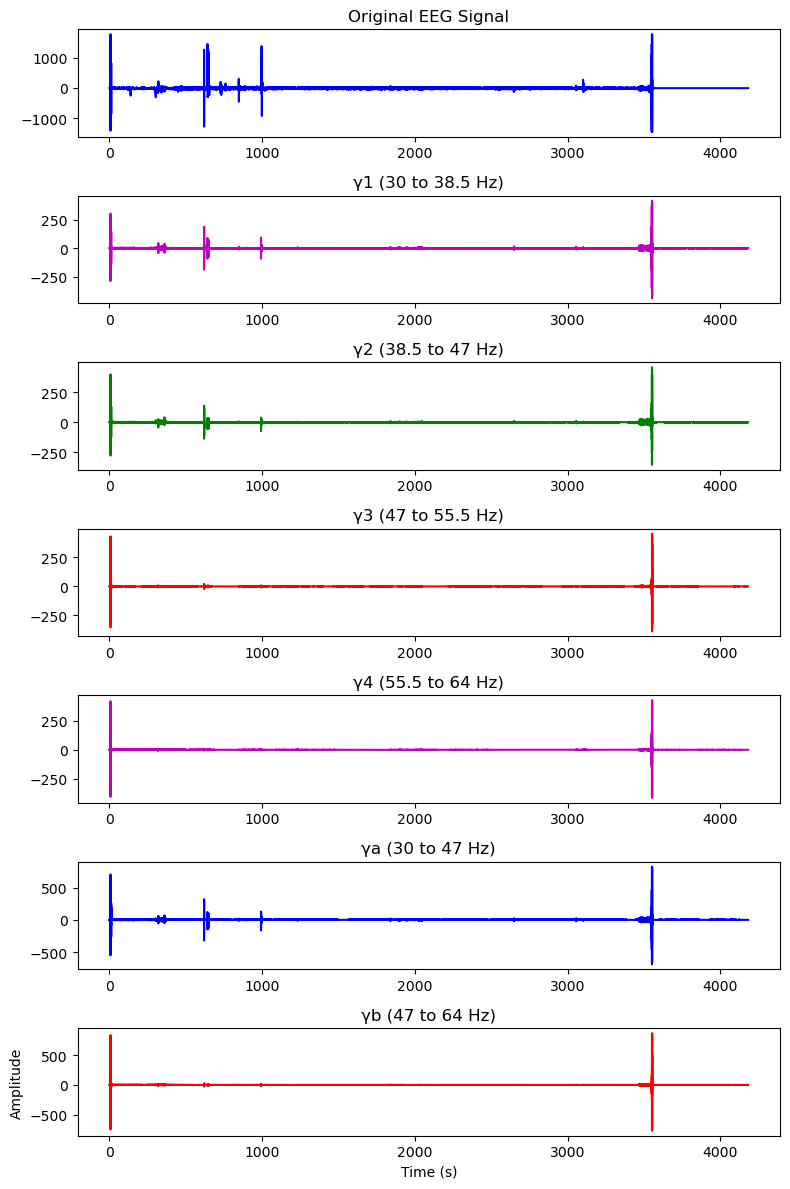

In [14]:
# Define the EEG signal
eeg_signal = E78_copy  # Replace with your actual EEG signal

# Define the frequency bands
gamma_1 = (30,38.5)
gamma_2 = (38.6,47)
gamma_3 = (47,55.5)
gamma_4 = (55.5,63.5)
gamma_a = (30,47)
gamma_b = (47,63.5)


# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
gamma_1_filtered = bandpass_filter(eeg_signal, gamma_1[0], gamma_1[1], fs)
gamma_2_filtered = bandpass_filter(eeg_signal, gamma_2[0], gamma_2[1], fs)
gamma_3_filtered = bandpass_filter(eeg_signal, gamma_3[0], gamma_3[1], fs)
gamma_4_filtered = bandpass_filter(eeg_signal, gamma_4[0], gamma_4[1], fs)
gamma_a_filtered = bandpass_filter(eeg_signal, gamma_a[0], gamma_a[1], fs)
gamma_b_filtered = bandpass_filter(eeg_signal, gamma_b[0], gamma_b[1], fs)

# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

# Create a figure and subplots
fig, axs = plt.subplots(7, 1, figsize=(8, 12))


#plt.figure(figsize=(12, 8))

# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma 1 band filtered signal
axs[1].plot(time, gamma_1_filtered, 'm')
axs[1].set_title('γ1 (30 to 38.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma 2 band filtered signal
axs[2].plot(time, gamma_2_filtered, 'g')
axs[2].set_title('γ2 (38.5 to 47 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma 3 band filtered signal
axs[3].plot(time, gamma_3_filtered, 'r')
axs[3].set_title('γ3 (47 to 55.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma 4 band filtered signal
axs[4].plot(time, gamma_4_filtered, 'm')
axs[4].set_title('γ4 (55.5 to 64 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma a band filtered signal
axs[5].plot(time, gamma_a_filtered, 'b')
axs[5].set_title('γa (30 to 47 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Gamma b band filtered signal
axs[6].plot(time, gamma_b_filtered, 'r')
axs[6].set_title('γb (47 to 64 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


### Bandpass filtering with 60 seconds windowing

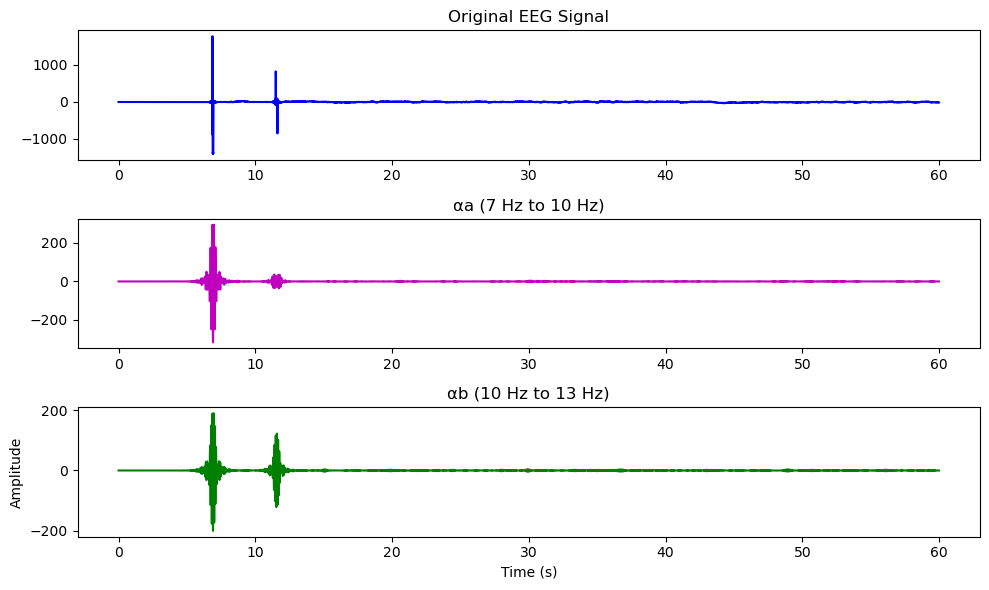

In [16]:
# Define the EEG signal
eeg_signal = w_78 # Replace with your actual EEG signal

# Define the frequency bands
alpha_a = (7,10)
alpha_b = (10,13)

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
alpha_a_filtered = bandpass_filter(eeg_signal, alpha_a[0], alpha_a[1], fs)
alpha_b_filtered = bandpass_filter(eeg_signal, alpha_b[0], alpha_b[1], fs)


# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs



# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 6))


# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Alpha a band filtered signal
axs[1].plot(time, alpha_a_filtered, 'm')
axs[1].set_title('αa (7 Hz to 10 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Alpha b band filtered signal
axs[2].plot(time, alpha_b_filtered, 'g')
axs[2].set_title('αb (10 Hz to 13 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



plt.tight_layout()
plt.show()



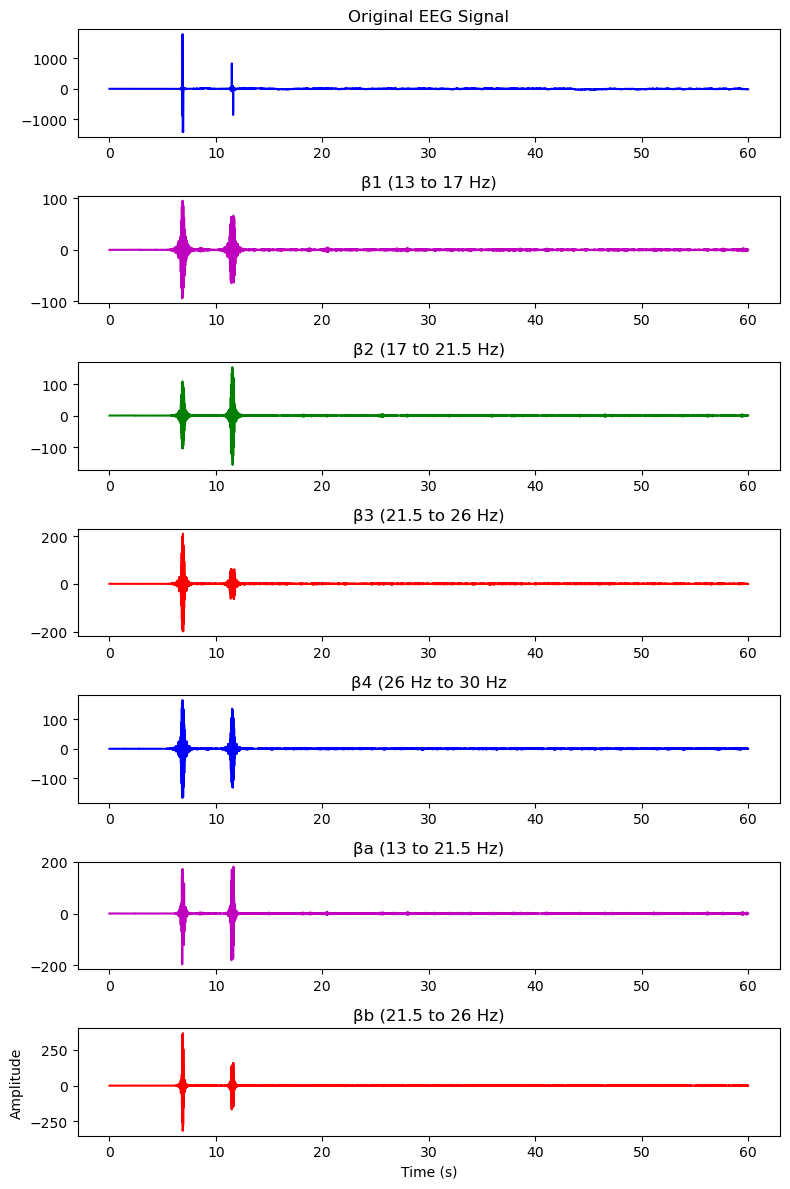

In [17]:
# Define the EEG signal
eeg_signal = w_78 # Replace with your actual EEG signal

# Define the frequency bands
beta_1 = (13,17)
beta_2 = (17,21.5)
beta_3 = (21.5,26)
beta_4 = (26,30)
beta_a = (13,21.5)
beta_b = (21.5,30)

# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
beta_1_filtered = bandpass_filter(eeg_signal, beta_1[0], beta_1[1], fs)
beta_2_filtered = bandpass_filter(eeg_signal, beta_2[0], beta_2[1], fs)
beta_3_filtered = bandpass_filter(eeg_signal, beta_3[0], beta_3[1], fs)
beta_4_filtered = bandpass_filter(eeg_signal, beta_4[0], beta_4[1], fs)
beta_a_filtered = bandpass_filter(eeg_signal, beta_a[0], beta_a[1], fs)
beta_b_filtered = bandpass_filter(eeg_signal, beta_b[0], beta_b[1], fs)

# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

# Create a figure and subplots
fig, axs = plt.subplots(7, 1, figsize=(8, 12))


#plt.figure(figsize=(12, 8))

# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 1 band filtered signal
axs[1].plot(time, beta_1_filtered, 'm')
axs[1].set_title('β1 (13 to 17 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 2 band filtered signal
axs[2].plot(time, beta_2_filtered, 'g')
axs[2].set_title('β2 (17 t0 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 3 band filtered signal
axs[3].plot(time, beta_3_filtered, 'r')
axs[3].set_title('β3 (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 4 band filtered signal
axs[4].plot(time, beta_4_filtered, 'b')
axs[4].set_title('β4 (26 Hz to 30 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta a band filtered signal
axs[5].plot(time, beta_a_filtered, 'm')
axs[5].set_title('βa (13 to 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beat b band filtered signal
axs[6].plot(time, beta_b_filtered, 'r')
axs[6].set_title('βb (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


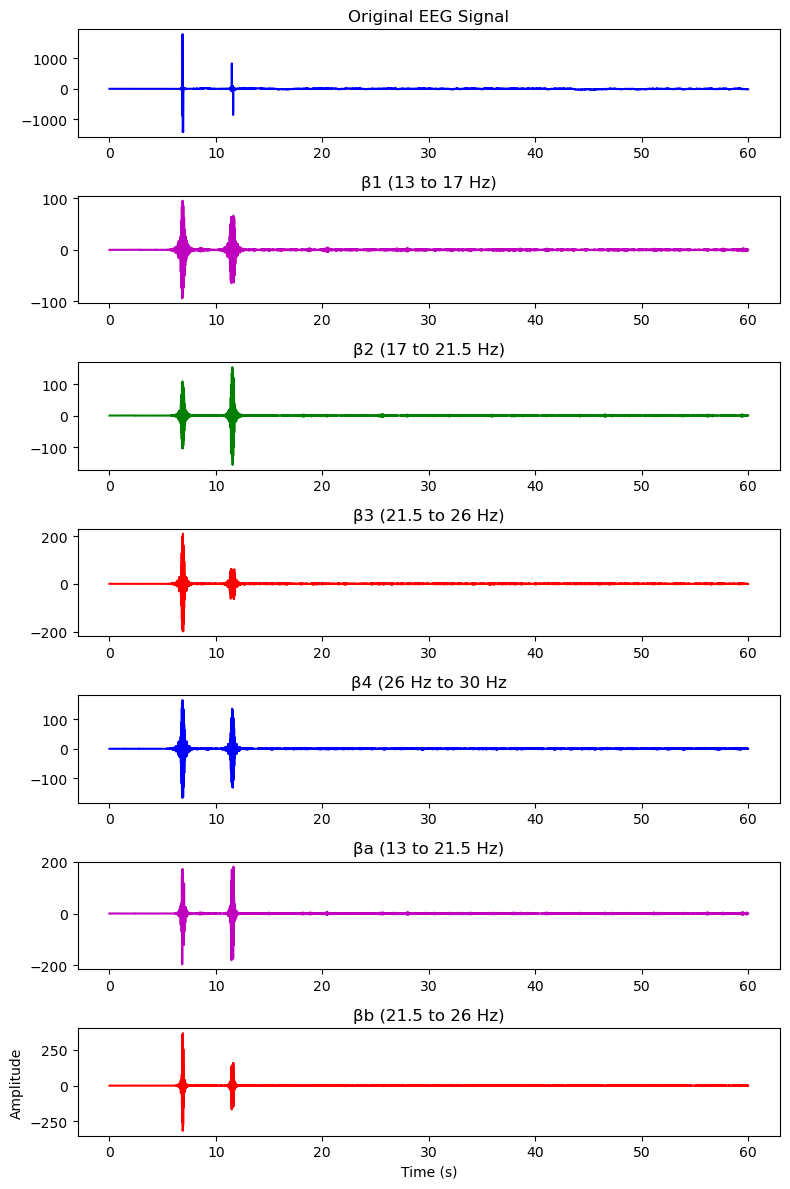

In [18]:
# Define the EEG signal
eeg_signal = w_78 # Replace with your actual EEG signal

# Define the frequency bands
beta_1 = (13,17)
beta_2 = (17,21.5)
beta_3 = (21.5,26)
beta_4 = (26,30)
beta_a = (13,21.5)
beta_b = (21.5,30)

# Apply bandpass filters to the EEG signal
fs = 128  # Replace with the actual sampling rate of your EEG signal
beta_1_filtered = bandpass_filter(eeg_signal, beta_1[0], beta_1[1], fs)
beta_2_filtered = bandpass_filter(eeg_signal, beta_2[0], beta_2[1], fs)
beta_3_filtered = bandpass_filter(eeg_signal, beta_3[0], beta_3[1], fs)
beta_4_filtered = bandpass_filter(eeg_signal, beta_4[0], beta_4[1], fs)
beta_a_filtered = bandpass_filter(eeg_signal, beta_a[0], beta_a[1], fs)
beta_b_filtered = bandpass_filter(eeg_signal, beta_b[0], beta_b[1], fs)

# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

# Create a figure and subplots
fig, axs = plt.subplots(7, 1, figsize=(8, 12))


#plt.figure(figsize=(12, 8))

# Original EEG signal
axs[0].plot(time, eeg_signal, 'b')
axs[0].set_title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 1 band filtered signal
axs[1].plot(time, beta_1_filtered, 'm')
axs[1].set_title('β1 (13 to 17 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 2 band filtered signal
axs[2].plot(time, beta_2_filtered, 'g')
axs[2].set_title('β2 (17 t0 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 3 band filtered signal
axs[3].plot(time, beta_3_filtered, 'r')
axs[3].set_title('β3 (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta 4 band filtered signal
axs[4].plot(time, beta_4_filtered, 'b')
axs[4].set_title('β4 (26 Hz to 30 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beta a band filtered signal
axs[5].plot(time, beta_a_filtered, 'm')
axs[5].set_title('βa (13 to 21.5 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Beat b band filtered signal
axs[6].plot(time, beta_b_filtered, 'r')
axs[6].set_title('βb (21.5 to 26 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


### Variational Mode Decomposition

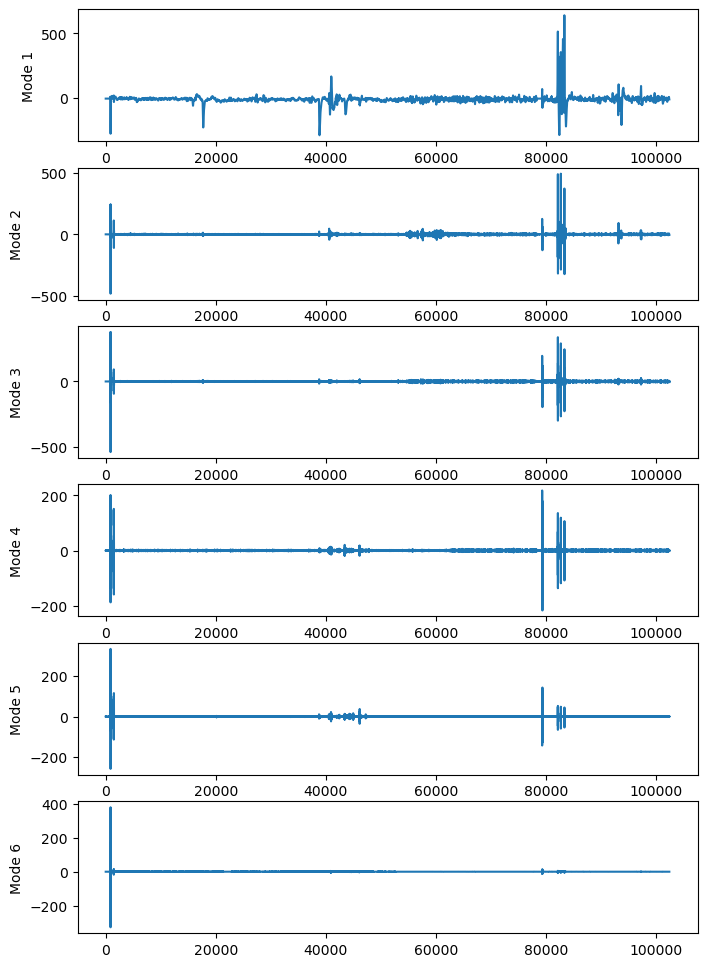

In [12]:
import numpy as np
from vmdpy import VMD

# Generate a sample signal
t = np.linspace(0, 1, 1000)
f1 = 10
f2 = 100

signal = w_78

# Set VMD parameters
alpha = 2000
tau = 0
K = 6
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(8, 12))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()


In [13]:
           
mode_table= pd.DataFrame(modes.T, columns=['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6'])
mode_table

,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6
0,-5.691651,0.133725,-0.001733,0.010688,-0.023695,-0.000852
1,-5.692424,0.128904,0.003792,-0.009004,0.040422,0.003345
2,-5.693268,0.120129,0.014327,-0.020752,-0.005006,-0.006805
3,-5.695254,0.106394,0.025743,-0.007516,-0.041502,0.008656
4,-5.698468,0.087925,0.034788,0.020675,0.037305,-0.006784
...,...,...,...,...,...,...
102395,-11.501247,-4.315956,-0.093089,0.614717,-0.265932,0.003138
102396,-11.629148,-4.536443,-1.653723,-0.350359,0.154075,-0.037176
102397,-11.706942,-4.681680,-2.988349,-0.757951,0.071609,0.034846
102398,-11.747649,-4.764859,-3.953383,-0.215312,-0.231362,-0.036311


In [14]:
import numpy as np

# Assuming EEG is a numpy array with shape (535191,)
EEG = modes[4]

# Define the window size
window_size = 128

# Calculate the number of windows
num_windows = len(EEG) // window_size

# Reshape the EEG signal into windows
EEG_windows = np.reshape(EEG[:num_windows * window_size], (num_windows, window_size))

# Calculate the mean of each window
mean_values = np.mean(EEG_windows, axis=1)

print(mean_values)


[-5.56221305e-04  1.82180820e-04 -4.38887704e-04 -1.16390793e-03
 -8.68919906e-05 -1.00740485e-03 -1.56108232e-01  1.55376025e-01
 -2.52779270e-03  2.37388150e-03 -5.53307051e-03 -5.83966273e-04
  4.56772490e-03 -2.65757152e-03  4.41476362e-03 -5.79910683e-03
  5.47223708e-03 -4.71154242e-03  3.64481331e-03 -4.68542867e-03
  3.35574323e-03 -4.57483930e-04  2.51024528e-03 -2.03308221e-03
 -3.85515233e-04 -4.77751371e-03  1.97662890e-03  4.11503027e-03
 -7.32323515e-03  1.53714786e-03  3.11335008e-03  8.03360230e-05
 -5.69686883e-03  3.13949957e-03  2.15285872e-03 -1.25024347e-04
 -1.31217597e-03 -1.31892146e-03 -5.21782777e-03  3.54870994e-03
  3.73598099e-03 -6.81303507e-03  2.56917237e-03  4.49216927e-03
 -7.87120704e-04 -3.34159859e-03 -2.87832077e-04 -2.01845403e-03
 -1.05163306e-03  1.45172869e-03 -1.39381155e-03 -7.71133175e-04
 -5.64913080e-03  5.35498358e-03  1.67593713e-04 -7.36411230e-04
 -7.53823621e-03  5.74139495e-03 -4.24519429e-03  5.03721929e-03
 -3.52696451e-03 -2.90267

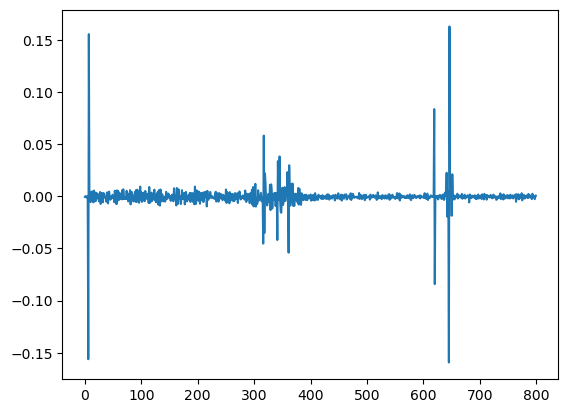

In [15]:
plt.plot(mean_values)

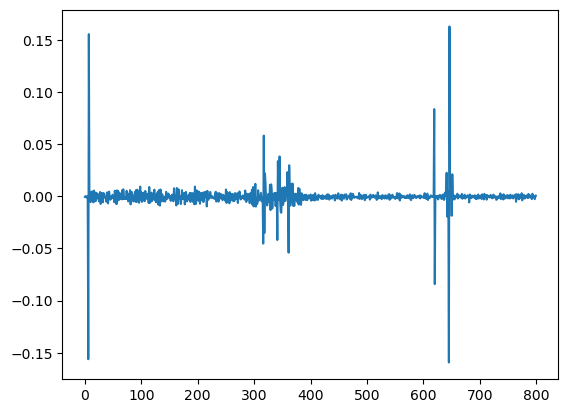

In [16]:
import numpy as np

# Assuming EEG is a numpy array with shape (535191,)
EEG = modes[4]

# Define the window size
window_size = 128

# Calculate the number of windows
num_windows = len(EEG) // window_size

# Reshape the EEG signal into windows
EEG_windows = np.reshape(EEG[:num_windows * window_size], (num_windows, window_size))

# Calculate the mean of each window
mean_values = np.mean(EEG_windows, axis=1)

test=[]
for i in EEG_windows:
    test.append(np.mean(i))
test
plt.plot(test)

In [ ]:
import numpy as np
from antropy import sample_entropy

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    sample_entropies = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]

        # Calculate sample entropy within the window
        sample_entropy = ant.sample_entropy(window)
        sample_entropies.append(sample_entropy)

    return sample_entropies

# Example usage with VMD modes
vmd_modes = modes
window_size_sec = 56       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies for each mode
mode_sample_entropies = []
for mode in vmd_modes:
    mode_sample_entropies.append(moving_sliding_window(mode, window_size_sec, overlap_sec, sampling_rate))

# Plotting the sample entropies for each mode
fig, axs = plt.subplots(len(vmd_modes), 1, figsize=(8, 6), sharex=True)
for i, sample_entropies in enumerate(mode_sample_entropies):
    axs[i].plot(sample_entropies)
    axs[i].set_ylabel("Sample Entropy")
    axs[i].set_title("Mode {}".format(i+1))
axs[-1].set_xlabel("Window Index")
plt.tight_layout()
plt.show()